# Medical Image classification with TensorFlow Lite Model Maker with TensorFlow 2.0

Model Maker library simplifies the process of adapting and converting a TensorFlow neural-network model to particular input data when deploying this model for on-device ML applications.

This notebook shows an end-to-end example that utilizes this Model Maker library to illustrate the adaption and conversion of a commonly-used image classification model to classify flowers on a mobile device.

## Prerequisites

To run this example, we first need to make a copy of this notebook. Click on "Copy to Drive" at the top of this notebook. Then we need to install serveral required packages, including Model Maker package that in github [repo](https://github.com/tensorflow/examples/tree/master/tensorflow_examples/lite/model_maker).

In [1]:
!pip install -q tflite-model-maker

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
anaconda-project 0.9.1 requires ruamel-yaml, which is not installed.
ei-for-tf 1.6.0 requires tensorflow<2.4.0,>=2.3.0, but you have tensorflow 2.5.0 which is incompatible.
aiobotocore 1.3.0 requires botocore<1.20.50,>=1.20.49, but you have botocore 1.20.83 which is incompatible.


Import the required packages.

In [2]:
from tflite_model_maker import image_classifier
from tflite_model_maker.image_classifier import DataLoader
import tensorflow as tf
assert tf.__version__.startswith('2')
import matplotlib.pyplot as plt
import numpy as np
import os
from tflite_model_maker import model_spec
from tflite_model_maker.config import ExportFormat
from tflite_model_maker.config import QuantizationConfig

## Simple End-to-End Execution

### Get the data path

Upload images folders to Google drive. Images with the same label will be in a same folder.

In [4]:
image_path = '/content/drive/MyDrive/MedicalClassification/oct_1000'

You could replace `image_path` with your own image folders.

### Exploring data and training


1.   Load input data specific to an on-device ML app. Split it to training data and testing data.

In [5]:
data = DataLoader.from_folder(image_path)
train_data, rest_data = data.split(0.8)
validation_data, test_data = rest_data.split(0.5)
data.index_to_label

INFO:tensorflow:Load image with size: 4000, num_label: 4, labels: choroidal neovascularization, diabetic macular edema, drusen, normal.


['choroidal neovascularization', 'diabetic macular edema', 'drusen', 'normal']

2.  Show 25 image examples with labels.



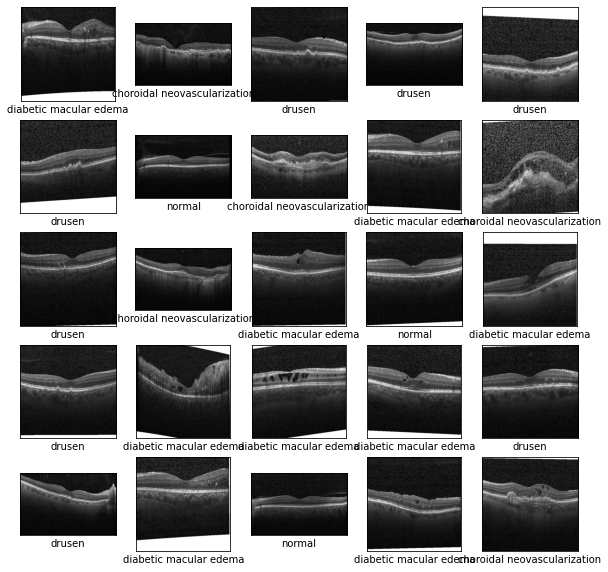

In [7]:
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(data.gen_dataset().unbatch().take(25)):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)
  plt.xlabel(data.index_to_label[label.numpy()])
plt.show()

3. Train the TensorFlow model.

In [14]:
model = image_classifier.create(train_data, validation_data=validation_data, epochs=10, batch_size = 20, dropout_rate = 0.2, use_augmentation = True)

INFO:tensorflow:Retraining the models...


INFO:tensorflow:Retraining the models...


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hub_keras_layer_v1v2_4 (HubK (None, 1280)              3413024   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 5124      
Total params: 3,418,148
Trainable params: 5,124
Non-trainable params: 3,413,024
_________________________________________________________________
None
INFO:tensorflow:Use default resize_bicubic.


INFO:tensorflow:Use default resize_bicubic.


INFO:tensorflow:Use customized resize method bilinear


INFO:tensorflow:Use customized resize method bilinear


INFO:tensorflow:Use customized resize method bilinear


INFO:tensorflow:Use customized resize method bilinear
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
160/160 [==============================] - 23s 131ms/step - loss: 0.9443 - accuracy: 0.6697 - val_loss: 0.7097 - val_accuracy: 0.8125
Epoch 2/10
160/160 [==============================] - 21s 130ms/step - loss: 0.8171 - accuracy: 0.7478 - val_loss: 0.6480 - val_accuracy: 0.8675
Epoch 3/10
160/160 [==============================] - 21s 132ms/step - loss: 0.8163 - accuracy: 0.7569 - val_loss: 0.7289 - val_accuracy: 0.8225
Epoch 4/10
160/160 [==============================] - 21s 134ms/step - loss: 0.7793 - accuracy: 0.7778 - val_loss: 0.6283 - val_accuracy: 0.8775
Epoch 5/10
160/160 [==============================] - 22s 136ms/step - loss: 0.7756 - accuracy: 0.7797 - val_loss: 0.6282 - val_accuracy: 0.8600
Epoch 6/10
160/160 [==============================] - 23s 143ms/step - loss: 0.7739 - accuracy: 0.7853 - val_loss: 0.6118 - val_accuracy: 0.8950
Epoch 7/10
160/160 [==============================] - 25s 155ms/step - loss: 0.7755 - accuracy: 0.7844 - val_loss: 0.6343 - val_ac

4. Evaluate the model.

In [15]:
loss, accuracy = model.evaluate(test_data)

INFO:tensorflow:Use customized resize method bilinear


INFO:tensorflow:Use customized resize method bilinear


13/13 [==============================] - 8s 113ms/step - loss: 0.5819 - accuracy: 0.9000


5.  We could plot the predicted results in 100 test images. Predicted labels with red color are the wrong predicted results while others are correct.

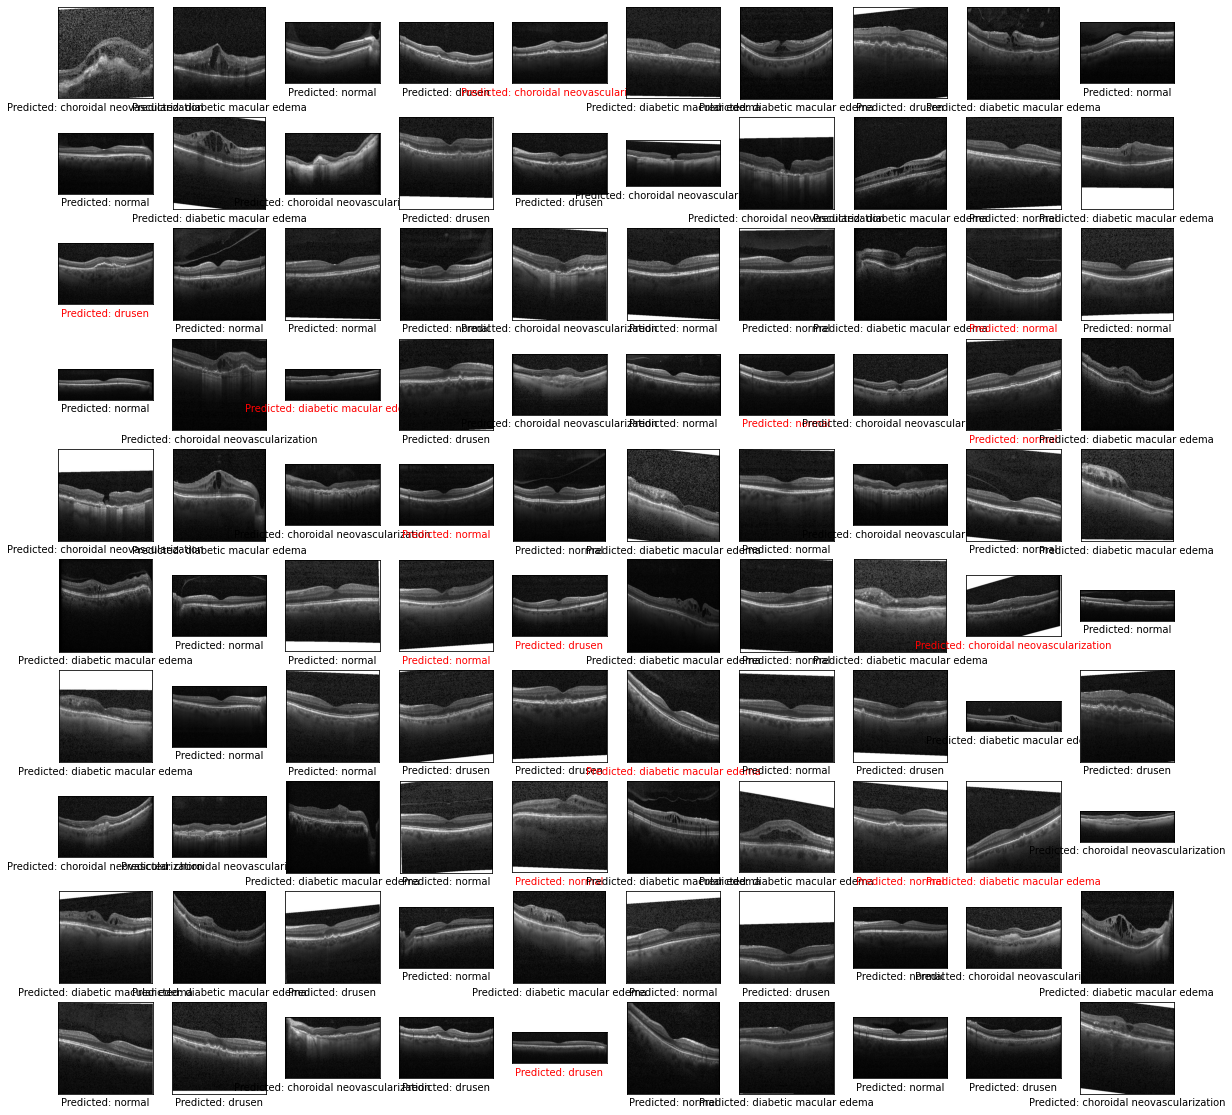

In [8]:
# A helper function that returns 'red'/'black' depending on if its two input
# parameter matches or not.
def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

# Then plot 100 test images and their predicted labels.
# If a prediction result is different from the label provided label in "test"
# dataset, we will highlight it in red color.
plt.figure(figsize=(20, 20))
predicts = model.predict_top_k(test_data)
for i, (image, label) in enumerate(test_data.gen_dataset().unbatch().take(100)):
  ax = plt.subplot(10, 10, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)

  predict_label = predicts[i][0][0]
  color = get_label_color(predict_label,
                          test_data.index_to_label[label.numpy()])
  ax.xaxis.label.set_color(color)
  plt.xlabel('Predicted: %s' % predict_label)
plt.show()

6.  Export to TensorFlow Lite model.
You could download it in the left sidebar.

In [16]:
model.export(export_dir='.', export_format=[ExportFormat.LABEL, ExportFormat.TFLITE])

INFO:tensorflow:Use customized resize method bilinear


INFO:tensorflow:Use customized resize method bilinear


INFO:tensorflow:Assets written to: /tmp/tmpdy_4h6dp/assets


INFO:tensorflow:Assets written to: /tmp/tmpdy_4h6dp/assets


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Saving labels in /tmp/tmpruskdm0r/labels.txt


INFO:tensorflow:Saving labels in /tmp/tmpruskdm0r/labels.txt


INFO:tensorflow:TensorFlow Lite model exported successfully: ./model.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully: ./model.tflite


INFO:tensorflow:Saving labels in ./labels.txt


INFO:tensorflow:Saving labels in ./labels.txt


7. Download the trained model by clicking on the folder icon on the left hand side. Right-click on "model.tflite" and select download. Or run the following code:

In [17]:
from google.colab import files
files.download('model.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

8.  You can also evaluate the tflite model with the evaluate_tflite method.



In [ ]:
model.evaluate_tflite('model.tflite', test_data)

{'accuracy': 0.8148854961832062}

### Customize Post-training quantization on the TensorFLow Lite model

In [ ]:
config = QuantizationConfig.for_float16()

In [ ]:
model.export(export_dir='.', tflite_filename='model_fp16.tflite', quantization_config=config)

INFO:tensorflow:Assets written to: /tmp/tmp5u33xhyi/assets


INFO:tensorflow:Assets written to: /tmp/tmp5u33xhyi/assets


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Saving labels in /tmp/tmp93z5c9ba/labels.txt


INFO:tensorflow:Saving labels in /tmp/tmp93z5c9ba/labels.txt


INFO:tensorflow:TensorFlow Lite model exported successfully: ./model_fp16.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully: ./model_fp16.tflite


### You can choose to use MobileNetV2 model

#### Change to the model that's supported in the library.

The library supports EfficientNet-Lite models, MobileNetV2, ResNet50 by now. EfficientNet-Lite are a family of image classification models that could achieve state-of-art accuracy and suitable for Edge devices. The default model is EfficientNet-Lite0.

You could switch model to MobileNetV2 by just setting parameter model_spec to the MobileNetV2 model specification in create method.

In [ ]:

model = image_classifier.create(train_data, model_spec=model_spec.get('mobilenet_v2'), validation_data=validation_data, epochs=10)


INFO:tensorflow:Retraining the models...


INFO:tensorflow:Retraining the models...


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hub_keras_layer_v1v2_1 (HubK (None, 1280)              2257984   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________
None
Epoch 1/10
130/130 [==============================] - 201s 2s/step - loss: 0.9147 - accuracy: 0.6484 - val_loss: 1.1089 - val_accuracy: 0.5625
Epoch 2/10
130/130 [==============================] - 191s 1s/step - loss: 0.7872 - accuracy: 0.7262 - val_loss: 0.8205 - val_accuracy: 0.6562
Epoch 3/10
130/130 [==============================] - 196s 2s/step - loss: 0.72

In [ ]:
loss, accuracy = model.evaluate(test_data)


17/17 [==============================] - 39s 1s/step - loss: 0.6741 - accuracy: 0.7844


In [ ]:
model.evaluate_tflite('model.tflite', test_data)

{'accuracy': 0.8148854961832062}

In [ ]:
model.export(export_dir='.', tflite_filename='pn_sub_mobilenet_v2.tflite', export_format=[ExportFormat.LABEL, ExportFormat.TFLITE])

INFO:tensorflow:Assets written to: /tmp/tmpsym9spxe/assets


INFO:tensorflow:Assets written to: /tmp/tmpsym9spxe/assets


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Saving labels in /tmp/tmpkyf6ps2d/labels.txt


INFO:tensorflow:Saving labels in /tmp/tmpkyf6ps2d/labels.txt


INFO:tensorflow:TensorFlow Lite model exported successfully: ./pn_sub_mobilenet_v2.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully: ./pn_sub_mobilenet_v2.tflite


INFO:tensorflow:Saving labels in ./labels.txt


INFO:tensorflow:Saving labels in ./labels.txt


In [ ]:
from google.colab import files
files.download('pn_sub_mobilenet_v2.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
config = QuantizationConfig.for_float16()
model.export(export_dir='.', tflite_filename='pn_sub_mobilenet_v2_quant.tflite', quantization_config=config)

INFO:tensorflow:Assets written to: /tmp/tmpelge5o8k/assets


INFO:tensorflow:Assets written to: /tmp/tmpelge5o8k/assets


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Saving labels in /tmp/tmpbzie5lvq/labels.txt


INFO:tensorflow:Saving labels in /tmp/tmpbzie5lvq/labels.txt


INFO:tensorflow:TensorFlow Lite model exported successfully: ./pn_sub_mobilenet_v2_quant.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully: ./pn_sub_mobilenet_v2_quant.tflite


In [ ]:
files.download('pn_sub_mobilenet_v2_quant.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# model = image_classifier.ModelSpec()